In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! pip install tensorflow_addons

## Download Dataset

In [ ]:

! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images
! unzip alzheimers-dataset-4-class-of-images.zip


## Creating two categories: Demented and Non-Demented

In [4]:
import os
import shutil

sourceTrain = ['/content/Alzheimer_s Dataset/train/ModerateDemented', '/content/Alzheimer_s Dataset/train/MildDemented']
destinationTrain = '/content/Alzheimer_s Dataset/train/VeryMildDemented'

sourceTest = ['/content/Alzheimer_s Dataset/test/ModerateDemented', '/content/Alzheimer_s Dataset/test/MildDemented']
destinationTest = '/content/Alzheimer_s Dataset/test/VeryMildDemented'


for source in sourceTrain:

  allfiles = os.listdir(source)

  for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destinationTrain, f)
    shutil.move(src_path, dst_path)



for source in sourceTest:

  allfiles = os.listdir(source)

  for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destinationTest, f)
    shutil.move(src_path, dst_path)

import os

old_name_test = r"/content/Alzheimer_s Dataset/test/VeryMildDemented"
new_name_test = r"/content/Alzheimer_s Dataset/test/Demented"
old_name_train = r"/content/Alzheimer_s Dataset/train/VeryMildDemented"
new_name_train = r"/content/Alzheimer_s Dataset/train/Demented"
os.rename(old_name_train, new_name_train)
os.rename(old_name_test, new_name_test)

%rmdir '/content/Alzheimer_s Dataset/test/MildDemented'
%rmdir '/content/Alzheimer_s Dataset/test/ModerateDemented'
%rmdir '/content/Alzheimer_s Dataset/train/MildDemented'
%rmdir '/content/Alzheimer_s Dataset/train/ModerateDemented'

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Found GPU at: /device:GPU:0
Number of replicas: 1
2.12.0


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100
NUM_CLASSES = 2

## Generating dataset

In [7]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)


train_ds = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208),
                                                 subset="training",
                                                 class_mode='binary')

val_ds = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208),
                                                 subset="validation",
                                                 class_mode='binary')

image_generator_test = ImageDataGenerator(rescale=1/255)
test_ds = image_generator_test.flow_from_directory(
                                                 directory='/content/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 target_size=(176,208),
                                                 class_mode='binary')

Found 4097 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.
Found 1098 images belonging to 2 classes.


## Visulaization of data

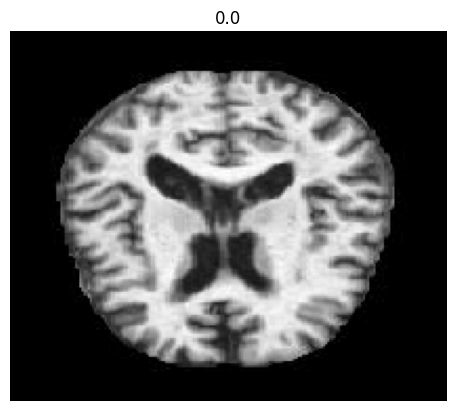

In [8]:
batch_1_img = train_ds[0]
img = batch_1_img[0][1]
lab = batch_1_img[1][1]
plt.imshow(img)
plt.title(lab)
plt.axis('off')
plt.show()

## CNN Model

In [9]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

with strategy.scope():
    CNN_model = build_model()

    METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc'),
          tfa.metrics.F1Score(num_classes = 1)
]

    CNN_model.compile(
        optimizer='adam',
        loss=tf.losses.BinaryCrossentropy(),
        metrics=METRICS
    )

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

## Training CNN

In [10]:

with tf.device('/device:GPU:0'):
  history = CNN_model.fit(train_ds,
                      validation_data = val_ds,
                      callbacks = [early_stopping_cb, lr_scheduler],
                      epochs = 100
                    )

Epoch 1/100
513/513 [==============================] - 51s 35ms/step - loss: 0.7044 - accuracy: 0.5802 - precision: 0.5915 - recall: 0.5176 - auc: 0.6145 - f1_score: 0.6666 - val_loss: 0.6916 - val_accuracy: 0.5469 - val_precision: 1.0000 - val_recall: 0.0938 - val_auc: 0.6057 - val_f1_score: 0.6667 - lr: 0.0100
Epoch 2/100
513/513 [==============================] - 18s 35ms/step - loss: 0.6612 - accuracy: 0.6090 - precision: 0.6332 - recall: 0.5176 - auc: 0.6412 - f1_score: 0.6666 - val_loss: 1.2726 - val_accuracy: 0.5293 - val_precision: 0.5161 - val_recall: 0.9395 - val_auc: 0.7445 - val_f1_score: 0.6667 - lr: 0.0089
Epoch 3/100
513/513 [==============================] - 17s 33ms/step - loss: 0.6485 - accuracy: 0.6295 - precision: 0.6734 - recall: 0.5024 - auc: 0.6563 - f1_score: 0.6666 - val_loss: 0.6978 - val_accuracy: 0.5029 - val_precision: 0.8000 - val_recall: 0.0078 - val_auc: 0.5661 - val_f1_score: 0.6667 - lr: 0.0079
Epoch 4/100
513/513 [==============================] - 17s

## Evaluation CNN

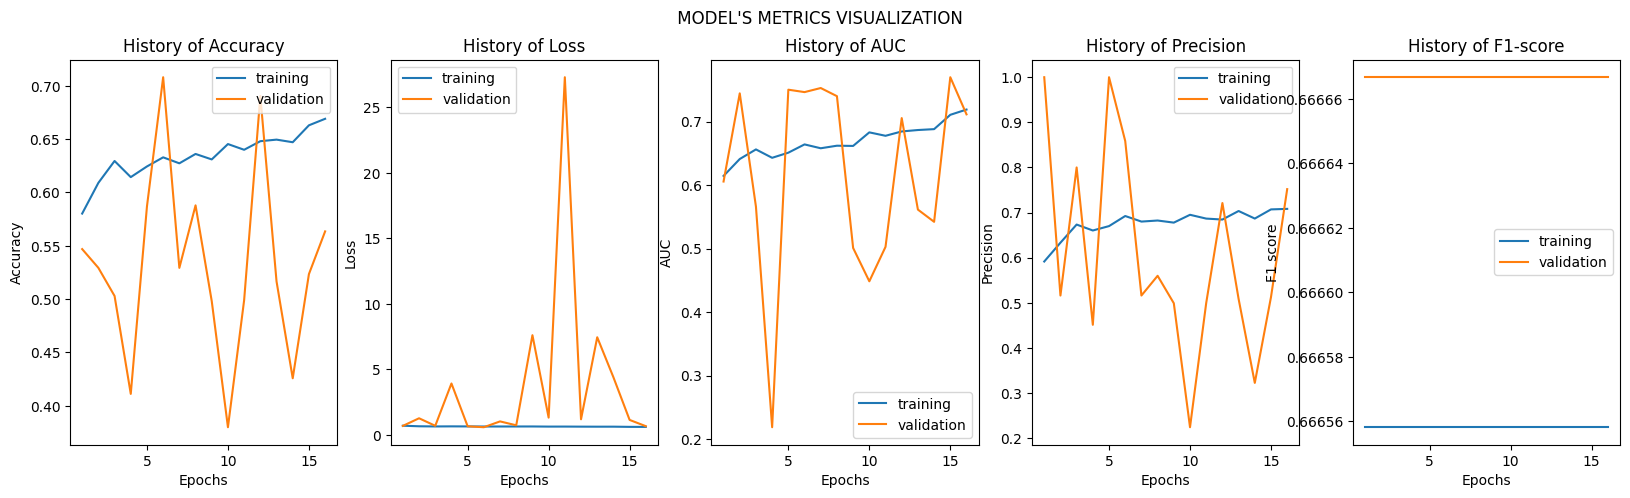

In [11]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [41]:
scorescnn = CNN_model.evaluate(test_ds)
print("Accuracy = ", scorescnn[1])
print("Precision = ", scorescnn[2])
print("Recall = ", scorescnn[3])
print("AUC = ", scorescnn[4])
print("F1_score = ", scorescnn[5])

35/35 [==============================] - 2s 61ms/step - loss: 0.5957 - accuracy: 0.6466 - precision: 0.6869 - recall: 0.7234 - auc: 0.7276 - f1_score: 0.7365
Accuracy =  0.6466302275657654
Precision =  0.6869435906410217
Recall =  0.723437488079071
AUC =  0.727638840675354
F1_score =  [0.73647875]


## VGG-19 Model

In [28]:
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0   

In [29]:
modelvgg.compile(optimizer='adam',
loss=tf.losses.BinaryCrossentropy(),
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tfa.metrics.F1Score(num_classes = 1)
])

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

## Training VGG-19

In [30]:
with tf.device('/device:GPU:0'):
  history = modelvgg.fit(train_ds, epochs=100, validation_data=val_ds, callbacks = [early_stopping_cb, lr_scheduler])

Epoch 1/100
513/513 [==============================] - 39s 73ms/step - loss: 1.4764 - accuracy: 0.6737 - precision: 0.6730 - recall: 0.6753 - auc: 0.7234 - f1_score: 0.6664 - val_loss: 1.0259 - val_accuracy: 0.6992 - val_precision: 0.7802 - val_recall: 0.5547 - val_auc: 0.7833 - val_f1_score: 0.6667 - lr: 0.0100
Epoch 2/100
513/513 [==============================] - 32s 62ms/step - loss: 1.1183 - accuracy: 0.7562 - precision: 0.7562 - recall: 0.7559 - auc: 0.8216 - f1_score: 0.6673 - val_loss: 1.3292 - val_accuracy: 0.6914 - val_precision: 0.8984 - val_recall: 0.4316 - val_auc: 0.8057 - val_f1_score: 0.6667 - lr: 0.0089
Epoch 3/100
513/513 [==============================] - 33s 63ms/step - loss: 0.6147 - accuracy: 0.8165 - precision: 0.8195 - recall: 0.8115 - auc: 0.8959 - f1_score: 0.6666 - val_loss: 0.8084 - val_accuracy: 0.7656 - val_precision: 0.8269 - val_recall: 0.6719 - val_auc: 0.8582 - val_f1_score: 0.6667 - lr: 0.0079
Epoch 4/100
513/513 [==============================] - 33s

## Evaluation VGG-19

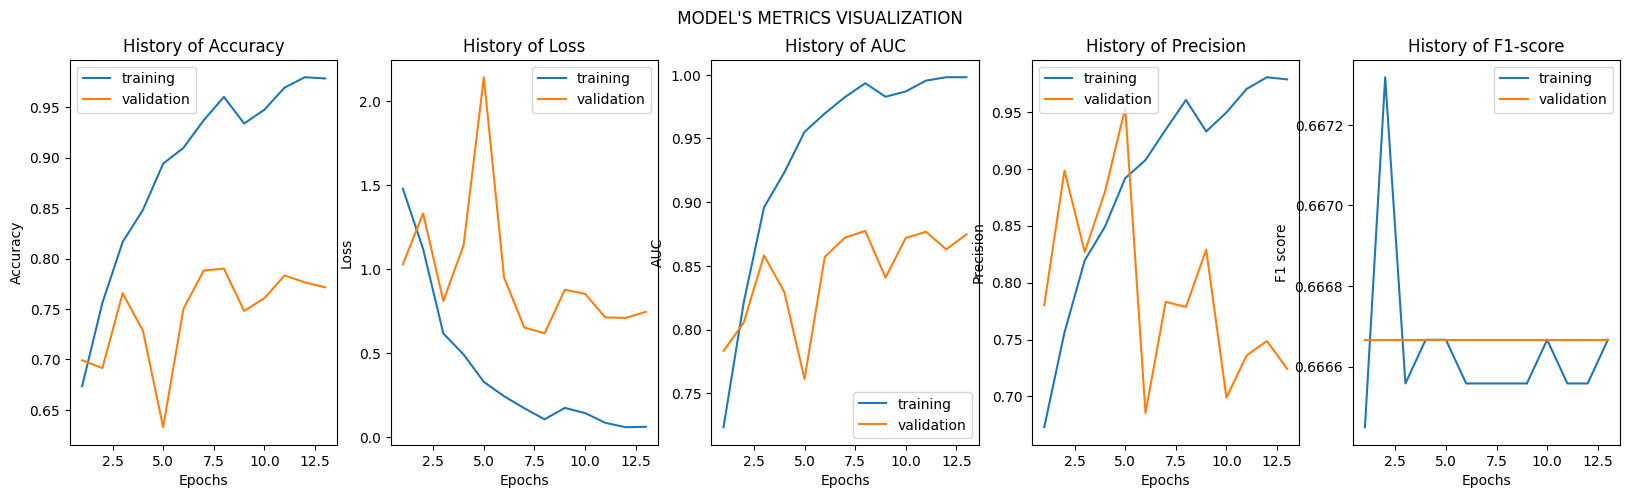

In [31]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [42]:
scoresvgg = modelvgg.evaluate(test_ds)
print("Accuracy = ", scoresvgg[1])
print("Precision = ", scoresvgg[2])
print("Recall = ", scoresvgg[3])
print("AUC = ", scoresvgg[4])
print("F1_score = ", scoresvgg[5])

35/35 [==============================] - 6s 160ms/step - loss: 0.7686 - accuracy: 0.7723 - precision: 0.8095 - recall: 0.7969 - auc: 0.8417 - f1_score: 0.7365
Accuracy =  0.7723132967948914
Precision =  0.8095238208770752
Recall =  0.796875
AUC =  0.8416637182235718
F1_score =  [0.73647875]


## ResNET-50 Model

In [33]:
rn = ResNet50(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(1, activation='sigmoid')(x)

modelrn = Model(inputs=rn.input, outputs=prediction)
modelrn.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 88, 104, 64)  256         ['conv1_conv[0][0]']       

In [34]:
modelrn.compile(optimizer='adam',
loss=tf.losses.BinaryCrossentropy(),
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tfa.metrics.F1Score(num_classes = 1)
])

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

## Training ResNET50

In [35]:
with tf.device('/device:GPU:0'):
  history = modelrn.fit(train_ds, epochs=100, validation_data=val_ds, callbacks = [early_stopping_cb, lr_scheduler])

Epoch 1/100
513/513 [==============================] - 25s 42ms/step - loss: 5.6818 - accuracy: 0.6021 - precision: 0.6021 - recall: 0.6021 - auc: 0.6215 - f1_score: 0.6698 - val_loss: 3.2301 - val_accuracy: 0.6973 - val_precision: 0.9040 - val_recall: 0.4414 - val_auc: 0.7499 - val_f1_score: 0.6779 - lr: 0.0100
Epoch 2/100
513/513 [==============================] - 19s 37ms/step - loss: 4.7081 - accuracy: 0.6356 - precision: 0.6356 - recall: 0.6353 - auc: 0.6549 - f1_score: 0.6748 - val_loss: 5.5465 - val_accuracy: 0.5537 - val_precision: 0.5289 - val_recall: 0.9824 - val_auc: 0.6022 - val_f1_score: 0.6667 - lr: 0.0089
Epoch 3/100
513/513 [==============================] - 19s 38ms/step - loss: 3.3744 - accuracy: 0.6878 - precision: 0.6877 - recall: 0.6880 - auc: 0.7292 - f1_score: 0.6828 - val_loss: 2.4635 - val_accuracy: 0.6973 - val_precision: 0.9469 - val_recall: 0.4180 - val_auc: 0.7898 - val_f1_score: 0.6746 - lr: 0.0079
Epoch 4/100
513/513 [==============================] - 21s

## Evaluation ResNET50

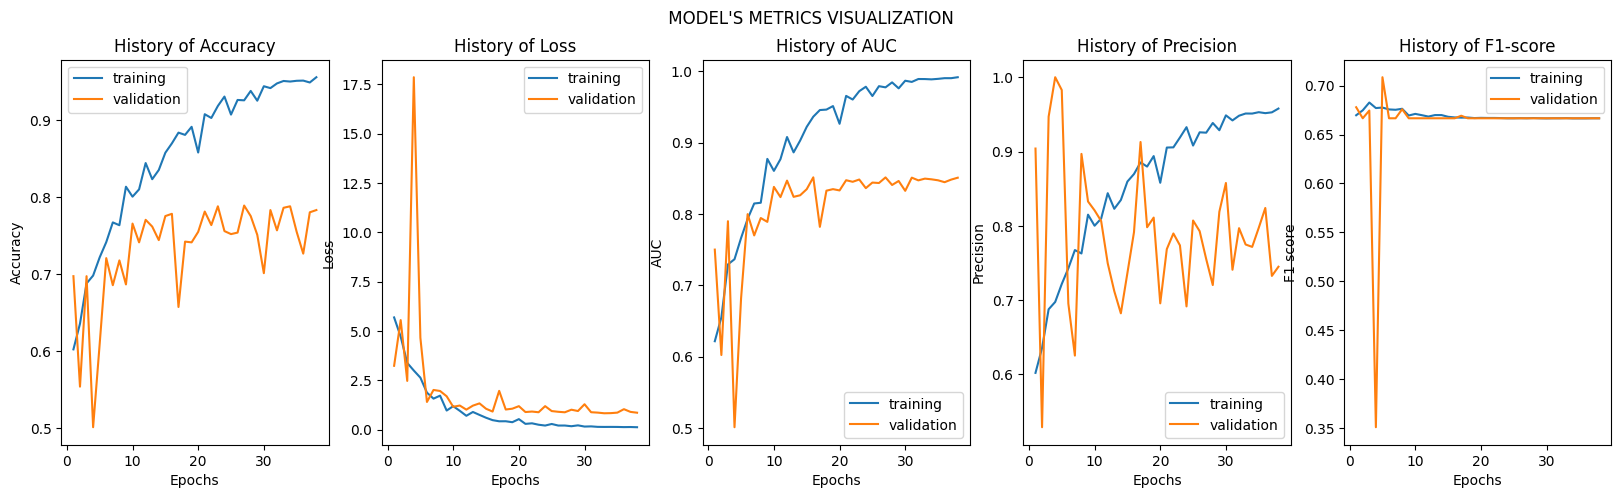

In [36]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [43]:
scoresrn = modelrn.evaluate(test_ds)
print("Accuracy = ", scoresrn[1])
print("Precision = ", scoresrn[2])
print("Recall = ", scoresrn[3])
print("AUC = ", scoresrn[4])
print("F1_score = ", scoresrn[5])

35/35 [==============================] - 3s 83ms/step - loss: 1.1724 - accuracy: 0.7468 - precision: 0.8187 - recall: 0.7266 - auc: 0.8073 - f1_score: 0.7378
Accuracy =  0.7468124032020569
Precision =  0.8186619877815247
Recall =  0.7265625
AUC =  0.8073247075080872
F1_score =  [0.7377522]


## Model Comparison

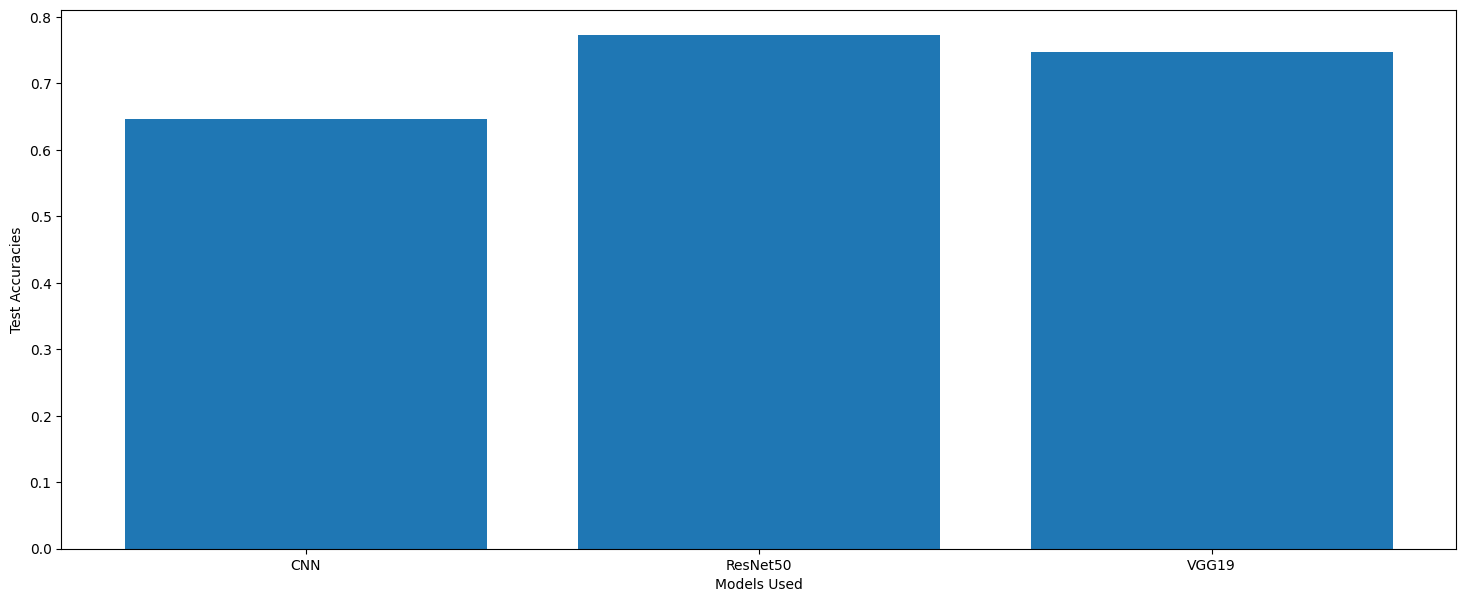

In [54]:
fig = plt.figure(figsize =(18, 7))

x=[scorescnn[1], scoresvgg[1], scoresrn[1]]
# Horizontal Bar Plot
plt.bar(y,x)
plt.ylabel("Test Accuracies")
plt.xlabel("Models Used")
# Show Plot
plt.show()

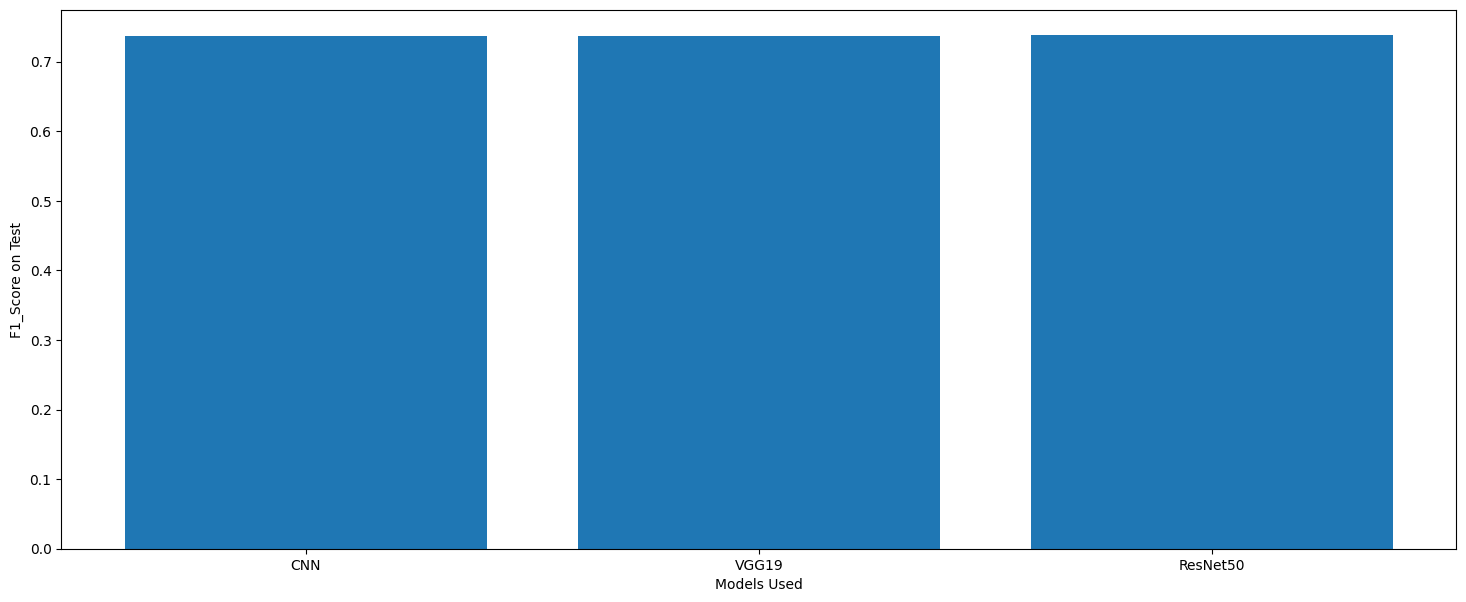

In [55]:
fig = plt.figure(figsize =(18, 7))
y = ["CNN", "VGG19", "ResNet50"]
x=[scorescnn[5][0], scoresvgg[5][0], scoresrn[5][0]]
# Horizontal Bar Plot
plt.bar(y,x)
plt.ylabel("F1_Score on Test")
plt.xlabel("Models Used")
# Show Plot
plt.show()

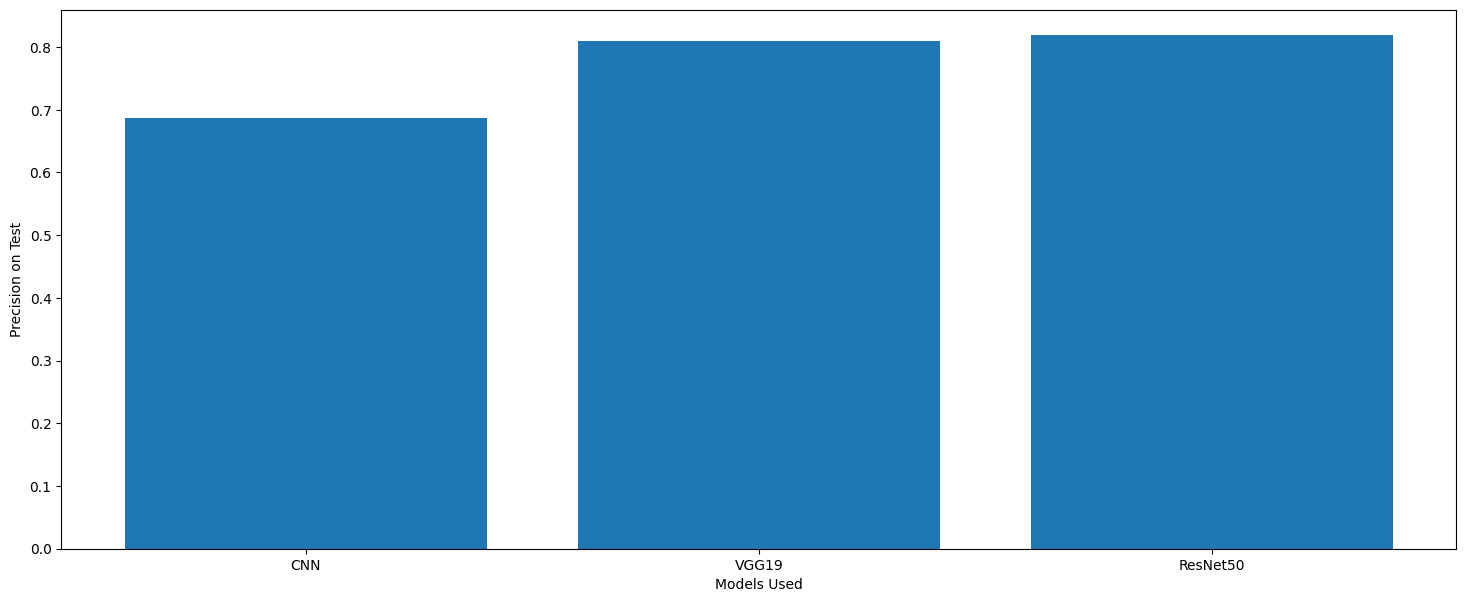

In [56]:
fig = plt.figure(figsize =(18, 7))
y = ["CNN", "VGG19", "ResNet50"]
x=[scorescnn[2], scoresvgg[2], scoresrn[2]]
# Horizontal Bar Plot
plt.bar(y,x)
plt.ylabel("Precision on Test")
plt.xlabel("Models Used")
# Show Plot
plt.show()

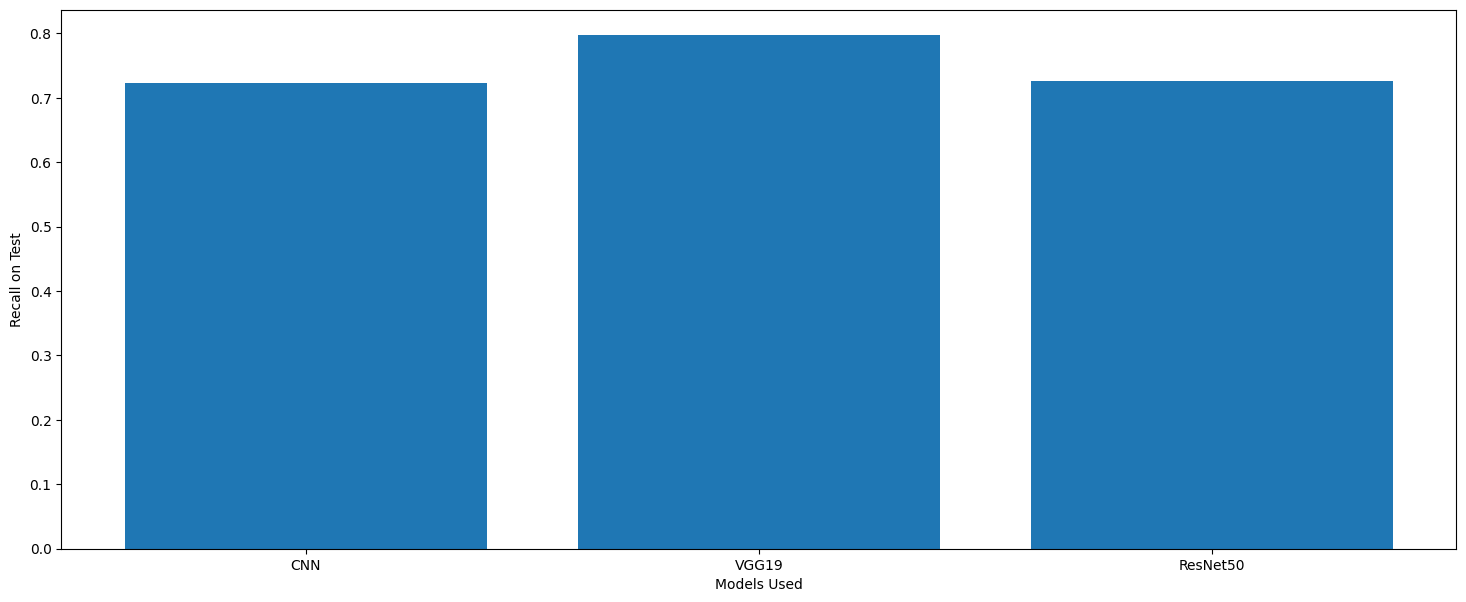

In [57]:
fig = plt.figure(figsize =(18, 7))
y = ["CNN", "VGG19", "ResNet50"]
x=[scorescnn[3], scoresvgg[3], scoresrn[3]]
# Horizontal Bar Plot
plt.bar(y,x)
plt.ylabel("Recall on Test")
plt.xlabel("Models Used")
# Show Plot
plt.show()

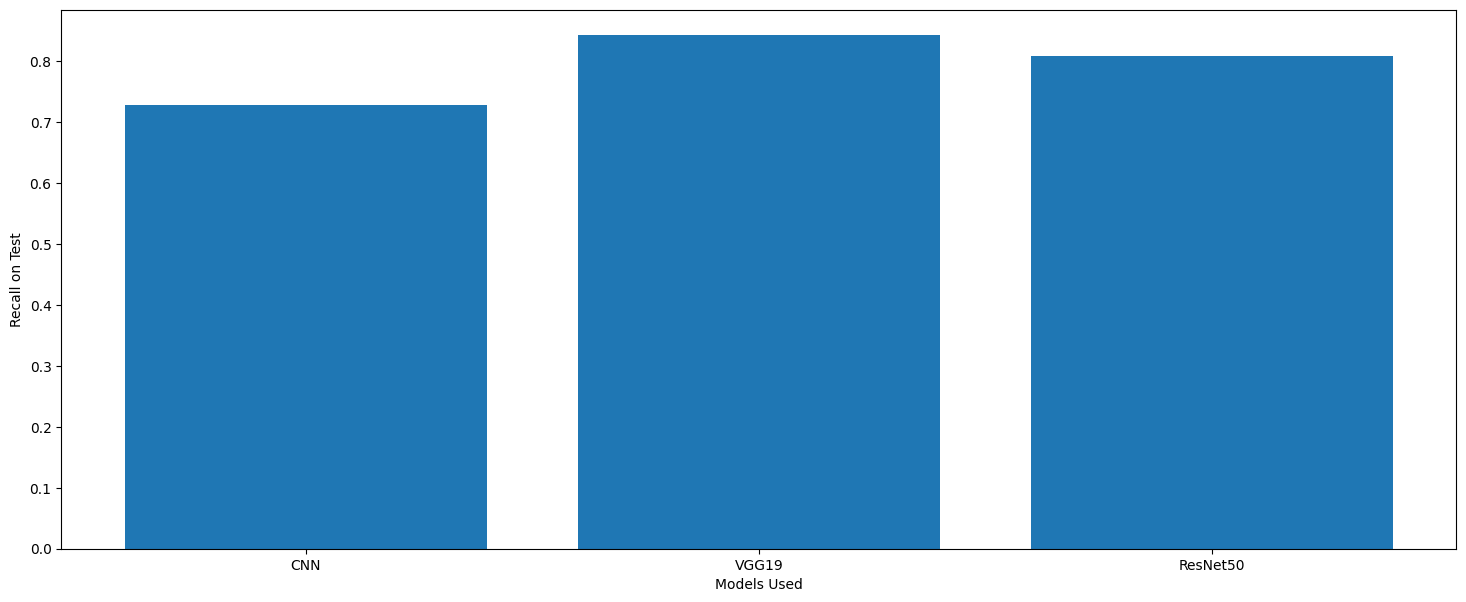

In [58]:
fig = plt.figure(figsize =(18, 7))
y = ["CNN", "VGG19", "ResNet50"]
x=[scorescnn[4], scoresvgg[4], scoresrn[4]]
# Horizontal Bar Plot
plt.bar(y,x)
plt.ylabel("Recall on Test")
plt.xlabel("Models Used")
# Show Plot
plt.show()

## Conclusion:
VGG-19 and ResNET50 performs better than traditional CNN model. Performance of VGG-19 and ResNET50 is similiar but VGG-19 has an edge over ResNET50 due to better recall.